In [ ]:
# STEP 2 : Estimate your own black-box machine learning model to forecast default.
# This script builds an XGBoost classifier with categorical encoding, hyperparameter search,
# evaluation metrics, and model persistence. It is organized as interactive cells.

In [ ]:
from __future__ import annotations
import os
from typing import Dict, Any, Tuple

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from joblib import dump, Memory
from tqdm.auto import tqdm

from xgboost import XGBClassifier

In [ ]:
# Removed Float32Caster to avoid pickling issues with joblib caching


def _infer_feature_types(df: pd.DataFrame, target_col: str) -> Tuple[list[str], list[str]]:
    """Infer categorical and numerical feature columns from a dataframe.

    - Categorical: dtype 'object' or 'category'
    - Numerical: all remaining columns except target
    """
    candidate_cols = [c for c in df.columns if c != target_col]
    categorical_cols = [c for c in candidate_cols if str(df[c].dtype) in ("object", "category")]
    numerical_cols = [c for c in candidate_cols if c not in categorical_cols]
    return categorical_cols, numerical_cols


def _drop_non_useful_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Drop common non-informative columns if present and columns with a single unique value.

    This is a conservative cleanup; adjust as needed for your dataset.
    """
    to_drop = [
        col for col in [
            "id", "ID", "Id", "index", "Index", "Unnamed: 0",
        ] if col in df.columns
    ]
    df = df.drop(columns=to_drop, errors="ignore")

    # Drop constant columns
    constant_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
    if constant_cols:
        df = df.drop(columns=constant_cols, errors="ignore")
    return df


def _sanitize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Replace infs with NaN and standardize string spacing for object/category columns."""
    df = df.replace([np.inf, -np.inf], np.nan)
    # Trim whitespace in string columns to avoid duplicate categories due to spacing
    obj_cols = [c for c in df.columns if str(df[c].dtype) in ("object", "category")]
    for c in obj_cols:
        df[c] = df[c].astype("string").str.strip()
    return df


def _prepare_binary_target(df: pd.DataFrame, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """Coerce the target to a clean binary 0/1 series and drop rows with missing target.

    Rules:
      - Drop rows where target is NA
      - If target is object/category: lowercase/strip and map common values; otherwise factorize
      - If numeric with two unique values: map {min->0, max->1}
      - If already 0/1 ints: keep
    """
    # Drop missing targets first
    df = df.copy()
    mask_notna = df[target_col].notna()
    if mask_notna.sum() < len(df):
        df = df.loc[mask_notna].copy()

    t = df[target_col]

    # Object/category handling
    if str(t.dtype) in ("object", "category", "string"):
        t_norm = t.astype("string").str.strip().str.lower()
        mapping = {
            "yes": 1, "y": 1, "true": 1, "t": 1, "1": 1, "default": 1,
            "no": 0, "n": 0, "false": 0, "f": 0, "0": 0, "non-default": 0,
        }
        mapped = t_norm.map(mapping)
        if mapped.isna().any():
            # Fallback: factorize to 0/1 if exactly two classes
            codes, uniques = pd.factorize(t_norm, sort=True)
            if len(uniques) != 2:
                raise ValueError(f"Target must be binary; found classes: {list(uniques)}")
            y = pd.Series(codes, index=df.index)
        else:
            y = mapped
        y = y.astype(int)
        return df, y

    # Numeric handling
    # Ensure finite
    t = pd.to_numeric(t, errors="coerce")
    if t.isna().any():
        # Missing after coercion -> cannot be used; drop those rows
        df = df.loc[t.notna()].copy()
        t = t.loc[df.index]

    unique_vals = sorted(pd.unique(t))
    if set(unique_vals).issubset({0, 1}):
        y = t.astype(int)
        return df, y
    if len(unique_vals) == 2:
        # Map min->0, max->1
        y = t.map({min(unique_vals): 0, max(unique_vals): 1}).astype(int)
        return df, y

    raise ValueError(f"Numeric target is not binary; unique values: {unique_vals}")


def _make_one_hot_encoder_sparse(min_frequency: float | int | None = None, max_categories: int | None = None) -> OneHotEncoder:
    """Create a sparse float32 OneHotEncoder with rare-category grouping and max_categories.

    Uses 'sparse_output' when available; falls back to 'sparse' for older sklearn.
    """
    common_kwargs = dict(handle_unknown="ignore", dtype=np.float32)
    if min_frequency is not None:
        common_kwargs["min_frequency"] = min_frequency
    if max_categories is not None:
        common_kwargs["max_categories"] = max_categories
    try:
        return OneHotEncoder(sparse_output=True, **common_kwargs)
    except TypeError:
        return OneHotEncoder(sparse=True, **common_kwargs)


def _print_feature_summary(df: pd.DataFrame, target_col: str) -> None:
    """Print column-wise summary: dtype, #unique, NA%, and sample unique values."""
    print("=== Column summary (before preprocessing) ===")
    for col in df.columns:
        dtype = df[col].dtype
        na_ratio = float(df[col].isna().mean())
        nunique = int(df[col].nunique(dropna=True))
        sample_vals = df[col].dropna().unique()[:5]
        print(f"- {col}: dtype={dtype}, unique={nunique}, na%={na_ratio:.3f}, sample={sample_vals}")
    if target_col in df.columns:
        print("Target value counts (non-null):")
        print(df[target_col].dropna().value_counts().head(10))


def _split_and_cast_feature_types(
    df: pd.DataFrame,
    target_col: str,
    numeric_parse_threshold: float = 0.98,
) -> Tuple[list[str], list[str], pd.DataFrame]:
    """Split features into categorical/numerical and cast numeric-like object columns.

    For object/category columns, attempt numeric coercion; if >= threshold values parse to
    numbers and there are at least 2 distinct numeric values, cast to float and mark as numerical.
    Otherwise, keep as categorical.
    """
    df = df.copy()
    candidate_cols = [c for c in df.columns if c != target_col]
    categorical_cols: list[str] = []
    numerical_cols: list[str] = []

    for col in candidate_cols:
        dtype = df[col].dtype
        if str(dtype) in ("object", "category", "string"):
            parsed = pd.to_numeric(df[col], errors="coerce")
            ratio = float(parsed.notna().mean())
            if ratio >= numeric_parse_threshold and parsed.nunique(dropna=True) >= 2:
                df[col] = parsed.astype(np.float32)
                numerical_cols.append(col)
            else:
                categorical_cols.append(col)
        else:
            # Downcast numeric dtypes to float32 if possible
            if np.issubdtype(dtype, np.floating):
                df[col] = df[col].astype(np.float32)
            numerical_cols.append(col)

    print("Numerical columns:", numerical_cols)
    print("Categorical columns:", categorical_cols)
    return categorical_cols, numerical_cols, df


def _print_ohe_cardinality_estimate(df: pd.DataFrame, categorical_cols: list[str], *, min_frequency: float | int | None, max_categories: int | None) -> None:
    """Estimate and print the number of OHE features given frequency grouping and cap."""
    print("=== OHE cardinality estimate ===")
    total_cols = 0
    for col in categorical_cols:
        vc = df[col].value_counts(dropna=True)
        n = len(vc)
        if min_frequency is not None:
            if isinstance(min_frequency, float):
                thr = int(np.ceil(min_frequency * len(df)))
            else:
                thr = int(min_frequency)
            kept = (vc >= thr).sum()
            has_other = kept < n
            est = kept + (1 if has_other else 0)
        else:
            est = n
        if max_categories is not None:
            est = min(est, max_categories)
        total_cols += est
        print(f"- {col}: unique={n} -> estimated OHE cols={est}")
    print(f"Estimated total OHE columns: {total_cols}")

In [ ]:
def train_xgboost_model(
    data_path: str,
    *,
    cost_fp: float = 1.0,
    cost_fn: float = 5.0,
    min_recall: float | None = None,
    threshold_strategy: str = "quantile",  # 'quantile' | 'linspace' | 'pr_subsample'
    max_thresholds: int = 2000,
) -> Tuple[XGBClassifier, Dict[str, Any]]:
    """Train an XGBoost classifier for default prediction and return model and metrics.

    Steps:
      - Load dataset (expects a 'target' column)
      - Clean and prepare features (OHE for categoricals)
      - Train/test split (70/30)
      - RandomizedSearchCV over key hyperparameters, scoring average_precision (PR-AUC)
      - Evaluate metrics and plot ROC + Precision-Recall
      - Tune threshold for best F1 and for minimum expected cost (cost_fp, cost_fn)
      - Save best model to models/xgb_default_model.pkl

    Returns
    -------
    model: XGBClassifier (best estimator)
    metrics: dict with accuracy, auc_roc, F1/cost threshold results, confusion matrices, best_params
    """
    # 1) Load data
    df = pd.read_csv(data_path)
    if "target" not in df.columns:
        raise ValueError("Dataset must contain a 'target' column.")

    df = _drop_non_useful_columns(df)
    df = _sanitize_dataframe(df)

    # Diagnostics: print types and basic stats before any coercion of target
    _print_feature_summary(df, target_col="target")

    # 2) Prepare target first (drop rows with missing/invalid target and coerce to 0/1)
    df, y = _prepare_binary_target(df, target_col="target")

    # 2a) Robustly identify feature types and cast numeric-like objects
    categorical_cols, numerical_cols, df_cast = _split_and_cast_feature_types(df, target_col="target")

    # Diagnostics: estimate OHE size with chosen settings
    ohe_min_freq = 0.01  # 1% of rows grouped into 'other'
    ohe_max_cat = 200    # cap categories per column
    _print_ohe_cardinality_estimate(df_cast, categorical_cols, min_frequency=ohe_min_freq, max_categories=ohe_max_cat)

    X = df_cast.drop(columns=["target"])  # features

    # 2b) Preprocessing pipelines with imputers
    categorical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", _make_one_hot_encoder_sparse(min_frequency=ohe_min_freq, max_categories=ohe_max_cat)),
    ])
    numerical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", categorical_pipeline, categorical_cols),
            ("num", numerical_pipeline, numerical_cols),
        ],
        remainder="drop",
        sparse_threshold=0.0,  # force sparse output if any transformer is sparse
    )

    # 3) Model and pipeline with caching
    xgb_clf = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="binary:logistic",
        eval_metric="aucpr",
        tree_method="hist",
        random_state=42,
        n_jobs=os.cpu_count() or 4,
        verbosity=0,
        max_bin=256,
    )

    cache_dir = os.path.join(os.path.dirname(os.path.dirname(__file__)), "models", "pipeline_cache")
    os.makedirs(cache_dir, exist_ok=True)
    memory = Memory(location=cache_dir, verbose=0)

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", xgb_clf),
    ], memory=memory)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y
    )

    # Handle class imbalance: scale_pos_weight
    pos = int((y_train == 1).sum())
    neg = int((y_train == 0).sum())
    if pos == 0:
        raise ValueError("No positive examples in training set after filtering.")
    base_spw = max(neg / pos, 1.0)
    print(f"Class imbalance: pos={pos}, neg={neg}, scale_pos_weight base={base_spw:.2f}")

    # 3b) Hyperparameter search space (RandomizedSearchCV)
    param_distributions = {
        "model__n_estimators": randint(200, 800),
        "model__max_depth": randint(3, 12),
        "model__learning_rate": uniform(0.01, 0.29),
        "model__subsample": uniform(0.6, 0.4),
        "model__colsample_bytree": uniform(0.6, 0.4),
        "model__scale_pos_weight": [base_spw * f for f in (0.5, 1.0, 2.0, 4.0, 8.0, 12.0)],
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=10,
        scoring="average_precision",
        n_jobs=os.cpu_count() or 4,
        cv=cv,
        verbose=1,
        random_state=42,
        refit=True,
    )

    search.fit(X_train, y_train)

    best_model: Pipeline = search.best_estimator_

    # 4) Evaluation at default threshold 0.5
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    f1_default = f1_score(y_test, y_pred)
    cm_default = confusion_matrix(y_test, y_pred)

    # Threshold tuning using precision-recall curve (for plotting)
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

    # Build a reduced thresholds scan for F1 and cost
    if threshold_strategy == "quantile":
        q = np.linspace(0.0, 1.0, max_thresholds)
        thresholds_scan = np.unique(np.quantile(y_proba, q))
    elif threshold_strategy == "linspace":
        thresholds_scan = np.linspace(0.0, 1.0, max_thresholds)
    else:  # 'pr_subsample'
        if len(thresholds) > max_thresholds:
            idx = np.linspace(0, len(thresholds) - 1, num=max_thresholds, dtype=int)
            thresholds_scan = thresholds[idx]
        else:
            thresholds_scan = thresholds
        thresholds_scan = np.unique(np.concatenate(([0.0], thresholds_scan, [1.0])))

    # Ensure within [0,1]
    thresholds_scan = thresholds_scan[(thresholds_scan >= 0.0) & (thresholds_scan <= 1.0)]
    thresholds_scan = np.unique(np.concatenate(([0.0], thresholds_scan, [1.0])))
    print(f"Scanning {len(thresholds_scan)} thresholds (strategy={threshold_strategy}, max={max_thresholds})")

    f1_per_thr = []
    prec_per_thr = []
    rec_per_thr = []
    cost_per_thr = []
    cms_per_thr = []
    for thr in tqdm(thresholds_scan, desc="Scanning thresholds for F1/Cost"):
        yp = (y_proba >= thr).astype(int)
        cm = confusion_matrix(y_test, yp)
        tn, fp, fn, tp = cm.ravel()
        p = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        r = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1_val = 2 * p * r / (p + r + 1e-12) if (p + r) > 0 else 0.0
        cost_val = cost_fp * fp + cost_fn * fn
        f1_per_thr.append(f1_val)
        prec_per_thr.append(p)
        rec_per_thr.append(r)
        cost_per_thr.append(cost_val)
        cms_per_thr.append(cm)

    f1_per_thr = np.array(f1_per_thr)
    prec_per_thr = np.array(prec_per_thr)
    rec_per_thr = np.array(rec_per_thr)
    cost_per_thr = np.array(cost_per_thr)

    # Best F1 threshold
    idx_f1 = int(np.argmax(f1_per_thr))
    best_threshold_f1 = float(thresholds_scan[idx_f1])
    best_f1 = float(f1_per_thr[idx_f1])
    best_precision_f1 = float(prec_per_thr[idx_f1])
    best_recall_f1 = float(rec_per_thr[idx_f1])
    cm_f1 = cms_per_thr[idx_f1].tolist()

    # Best cost threshold with optional recall constraint
    if min_recall is not None:
        valid = rec_per_thr >= float(min_recall)
        if valid.any():
            idx_cost = int(np.argmin(cost_per_thr[valid]))
            idx_cost = int(np.arange(len(thresholds_scan))[valid][idx_cost])
        else:
            idx_cost = int(np.argmin(cost_per_thr))
    else:
        idx_cost = int(np.argmin(cost_per_thr))

    best_threshold_cost = float(thresholds_scan[idx_cost])
    best_cost = float(cost_per_thr[idx_cost])
    best_precision_cost = float(prec_per_thr[idx_cost])
    best_recall_cost = float(rec_per_thr[idx_cost])
    cm_cost = cms_per_thr[idx_cost].tolist()

    metrics = {
        "accuracy": float(acc),
        "auc_roc": float(auc),
        "f1_score_default": float(f1_default),
        "confusion_matrix_default": cm_default.tolist(),
        "best_params": search.best_params_,
        # F1-optimal threshold
        "best_threshold_f1": best_threshold_f1,
        "f1_score_opt": best_f1,
        "precision_opt": best_precision_f1,
        "recall_opt": best_recall_f1,
        "confusion_matrix_opt": cm_f1,
        # Cost-optimal threshold
        "best_threshold_cost": best_threshold_cost,
        "expected_cost_min": best_cost,
        "precision_cost": best_precision_cost,
        "recall_cost": best_recall_cost,
        "confusion_matrix_cost": cm_cost,
        # For reference
        "cost_fp": float(cost_fp),
        "cost_fn": float(cost_fn),
        "min_recall": float(min_recall) if min_recall is not None else None,
        "threshold_strategy": threshold_strategy,
        "max_thresholds": int(max_thresholds),
        "thresholds_scanned": int(len(thresholds_scan)),
    }

    # Plot ROC and PR curves
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0])
    axes[0].set_title("ROC Curve")
    PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[1])
    axes[1].set_title("Precision-Recall Curve")
    # Mark optimal points on PR curve (F1 and Cost)
    axes[1].scatter([best_recall_f1], [best_precision_f1], color="red", label=f"Best F1={best_f1:.3f}")
    axes[1].scatter([best_recall_cost], [best_precision_cost], color="green", label=f"Min cost @thr={best_threshold_cost:.2f}")
    axes[1].legend()
    fig.tight_layout()
    plt.show()

    # Plot F1 vs threshold and Cost vs threshold
    fig2, axes2 = plt.subplots(1, 2, figsize=(12, 4))
    axes2[0].plot(thresholds_scan, f1_per_thr, label="F1 vs threshold")
    axes2[0].axvline(best_threshold_f1, color="red", linestyle="--", label=f"Best F1 thr={best_threshold_f1:.3f}")
    axes2[0].set_xlabel("Threshold")
    axes2[0].set_ylabel("F1 score")
    axes2[0].legend()

    axes2[1].plot(thresholds_scan, cost_per_thr, label=f"Cost (FP={cost_fp:.1f}, FN={cost_fn:.1f})")
    axes2[1].axvline(best_threshold_cost, color="green", linestyle="--", label=f"Min cost thr={best_threshold_cost:.3f}")
    if min_recall is not None:
        axes2[1].set_title(f"Cost vs threshold (min recall {min_recall:.2f})")
    else:
        axes2[1].set_title("Cost vs threshold")
    axes2[1].set_xlabel("Threshold")
    axes2[1].set_ylabel("Expected Cost")
    axes2[1].legend()
    fig2.tight_layout()
    plt.show()

    # 5) Save model
    models_dir = os.path.join(os.path.dirname(os.path.dirname(__file__)), "models")
    os.makedirs(models_dir, exist_ok=True)
    model_path = os.path.join(models_dir, "xgb_default_model.pkl")
    dump(best_model, model_path)

    print(f"Model saved to: {model_path}")
    print(
        f"Best F1 thr={best_threshold_f1:.4f} | F1={best_f1:.3f}, P={best_precision_f1:.3f}, R={best_recall_f1:.3f}\n"
        f"Min cost thr={best_threshold_cost:.4f} | cost={best_cost:.1f}, P={best_precision_cost:.3f}, R={best_recall_cost:.3f}"
    )

    return best_model, metrics

In [ ]:
# Example: data_path = os.path.join(os.path.dirname(os.path.dirname(__file__)), 'dataproject2025.csv')
data_path = "../data/dataproject2025.csv"

=== Column summary (before preprocessing) ===
- issue_d: dtype=int64, unique=9, na%=0.000, sample=[2013 2012 2014 2015 2016]
- loan duration: dtype=int64, unique=2, na%=0.000, sample=[0 1]
- annual_inc: dtype=float64, unique=52034, na%=0.000, sample=[ 39600.  55000. 325000. 130000.  73000.]
- avg_cur_bal: dtype=float64, unique=75432, na%=0.000, sample=[ 1379.  9570. 53306. 36362. 24161.]
- bc_open_to_buy: dtype=float64, unique=70954, na%=0.000, sample=[21564. 16473. 13901.  3567.  4853.]
- bc_util: dtype=float64, unique=1001, na%=0.000, sample=[16.1 53.9 67.1 93.  74.7]
- delinq_2yrs: dtype=float64, unique=31, na%=0.000, sample=[0. 1. 2. 3. 4.]
- dti: dtype=float64, unique=4812, na%=0.000, sample=[ 2.49 22.87 18.55 13.03 23.13]
- emp_length: dtype=string, unique=11, na%=0.000, sample=<StringArray>
['2 years', '10+ years', '5 years', '6 years', '4 years']
Length: 5, dtype: string
- emp_title: dtype=string, unique=51, na%=0.000, sample=<StringArray>
['other', 'sales manager', 'driver', '

Scanning thresholds for F1/Cost:   0%|          | 0/2002 [00:00<?, ?it/s]

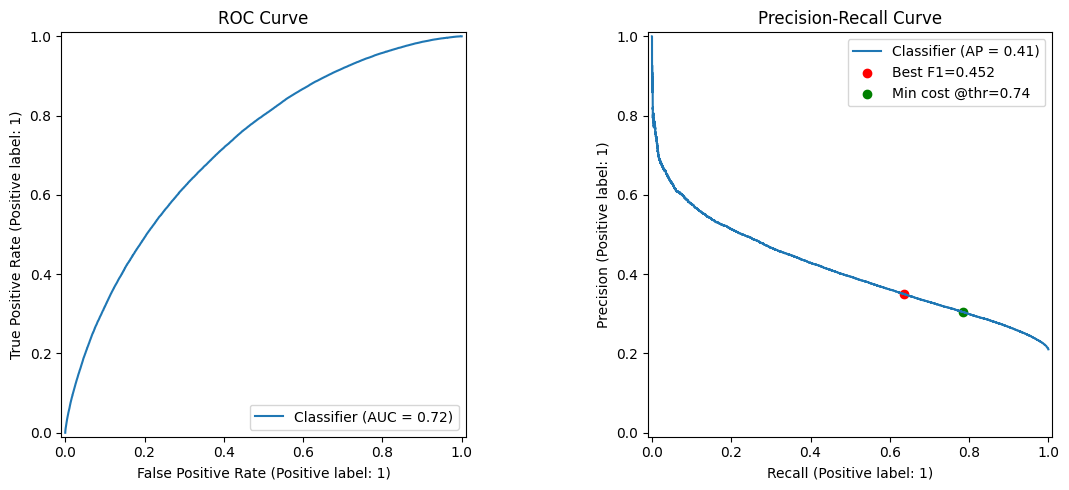

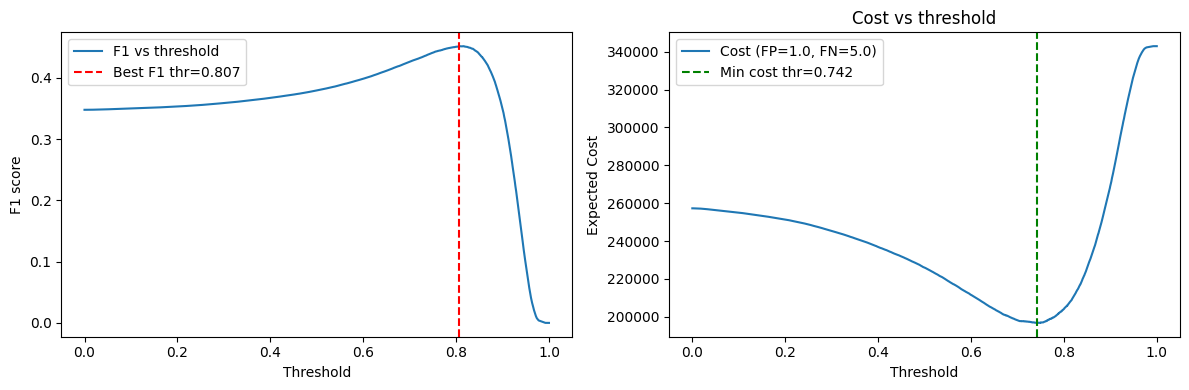

Model saved to: /Users/louisleibovici/Documents/VS_Code/DSB_HEC/Interpretability_Stability_ML_Project-1/models/xgb_default_model.pkl
Best F1 thr=0.8073 | F1=0.452, P=0.350, R=0.636
Min cost thr=0.7423 | cost=196737.0, P=0.304, R=0.785


In [ ]:
if os.path.exists(data_path):
    # Set costs here if needed, e.g., cost_fn >> cost_fp
    model, eval_metrics = train_xgboost_model(
        data_path,
        cost_fp=1.0,
        cost_fn=5.0,
        min_recall=None,
        threshold_strategy="quantile",
        max_thresholds=2000,
    )
else:
    print(f"CSV not found at: {data_path}. Please set 'data_path' to the correct location.")

In [ ]:
try:
    if 'eval_metrics' in globals():
        print("Best params:")
        for k, v in eval_metrics["best_params"].items():
            print(f"  {k}: {v}")
        print("\nMetrics:")
        print({k: v for k, v in eval_metrics.items() if k != 'best_params'})
except Exception as e:
    print(f"Unable to display metrics: {e}")

Best params:
  model__colsample_bytree: 0.6557975442608167
  model__learning_rate: 0.09472194807521325
  model__max_depth: 5
  model__n_estimators: 766
  model__scale_pos_weight: 15.002711584840116
  model__subsample: 0.836965827544817

Metrics:
{'accuracy': 0.33222655590709205, 'auc_roc': 0.7227568893933004, 'f1_score_default': 0.37937997319111316, 'confusion_matrix_default': [[41752, 215525], [2083, 66511]], 'best_threshold_f1': 0.8073394991804087, 'f1_score_opt': 0.45162292442184926, 'precision_opt': 0.35017865028704487, 'recall_opt': 0.635813628014112, 'confusion_matrix_opt': [[176345, 80932], [24981, 43613]], 'best_threshold_cost': 0.7422886677179532, 'expected_cost_min': 196737.0, 'precision_cost': 0.30446139320303267, 'recall_cost': 0.7850686648978045, 'confusion_matrix_cost': [[134255, 123022], [14743, 53851]], 'cost_fp': 1.0, 'cost_fn': 5.0, 'min_recall': None, 'threshold_strategy': 'quantile', 'max_thresholds': 2000, 'thresholds_scanned': 2002}
